In [96]:
import pandas as pd
import xgboost as xgb
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


class MLAlgorithms:
    def __init__(self, data, target_column='target'):
        self.data = data
        self.target_column = target_column
        self.X = None
        self.y = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
        self.best_xgb = None
        self.best_gb = None
        self.surrogate_dt_xgb = None
        self.surrogate_dt_gb = None

    def preprocess_features(self):
        """Prepares features and target for modeling."""
        print("Preprocessing data...")

        if 'date' in self.data.columns:
            self.data['date'] = pd.to_datetime(self.data['date'], errors='coerce')

        # Dropping unnecessary columns
        columns_to_drop = ['ALLSKY_SFC_LW_DWN', 'TS', 'T2M_RANGE', 'T2MDEW', 'GWETROOT']
        self.data = self.data.drop(columns=[col for col in columns_to_drop if col in self.data.columns], errors='ignore')

        # Creating date-related features
        if 'date' in self.data.columns:
            self.data['year'] = self.data['date'].dt.year
            self.data['month'] = self.data['date'].dt.month
            self.data['day'] = self.data['date'].dt.day
            self.data['weekday'] = self.data['date'].dt.weekday
            self.data['day_of_year'] = self.data['date'].dt.dayofyear

            # Cyclic encoding for month
            self.data['month_sin'] = np.sin(2 * np.pi * self.data['month'] / 12)
            self.data['month_cos'] = np.cos(2 * np.pi * self.data['month'] / 12)

        if self.target_column not in self.data.columns:
            raise ValueError(f"Target column '{self.target_column}' is missing from the dataset.")

        self.data = self.data.dropna(subset=[self.target_column])

        # Handling categorical features
        categorical_features = self.data.select_dtypes(include=['object']).columns
        categorical_features = [col for col in categorical_features if col != self.target_column]
        self.data = pd.get_dummies(self.data, columns=categorical_features, drop_first=True)

        # Define feature columns
        feature_columns = [col for col in self.data.columns if col not in [self.target_column, 'date']]
        self.X = self.data[feature_columns].fillna(self.data[feature_columns].mean())

        # Encode target variable
        self.y = self.data[self.target_column].astype(str)
        self.label_encoder.fit(self.y)
        self.y = self.label_encoder.transform(self.y)

        # Standardize features
        self.X = self.scaler.fit_transform(self.X)
        print("Preprocessing completed!")

    def train_xgboost(self, params=None):
        """Trains XGBoost classifier and returns accuracy."""
        if params is None:
            params = {'use_label_encoder': False, 'eval_metric': 'mlogloss'}
        
        print("Training XGBoost model...")
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.best_xgb = xgb.XGBClassifier(**params)
        self.best_xgb.fit(X_train, y_train)
        
        y_pred = self.best_xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"XGBoost Accuracy: {accuracy:.4f}")
        return X_train, X_test, y_train, y_test

    def train_gradient_boosting(self, params=None):
        """Trains Gradient Boosting classifier and returns accuracy."""
        if params is None:
            params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
        
        print("Training Gradient Boosting model...")
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.best_gb = GradientBoostingClassifier(**params)
        self.best_gb.fit(X_train, y_train)
        
        y_pred = self.best_gb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Gradient Boosting Accuracy: {accuracy:.4f}")
        return X_train, X_test, y_train, y_test

    def train_surrogate_dt(self, model, X_train, X_test, y_train, y_test, model_name='xgb'):
        """Trains a surrogate decision tree to approximate the model's predictions."""
        print(f"Training surrogate decision tree for {model_name}...")
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_train, y_train_pred)
        
        dt_accuracy = accuracy_score(y_test_pred, dt.predict(X_test))
        print(f"Surrogate Decision Tree Accuracy ({model_name}): {dt_accuracy:.4f}")

        if model_name == 'xgb':
            self.surrogate_dt_xgb = dt
        else:
            self.surrogate_dt_gb = dt

   
    def plot_combined_feature_importance(self):
        """Plots combined feature importance for all stations in one subplot."""
        print("Plotting combined feature importance for all stations...")

        # Ensure the models have been trained
        if self.best_xgb is None or self.best_gb is None:
            print("No trained models found.")
            return

        # Get feature importance from XGBoost model (this can also be done for Gradient Boosting)
        xgb_importance = self.best_xgb.feature_importances_

        # List of features (excluding target column and 'date')
        features = self.data.columns.drop([self.target_column, 'date'], errors='ignore')

        # Sort feature importance in descending order for clarity
        sorted_idx = np.argsort(xgb_importance)[::-1]  # Sort in descending order
        importance_sorted = xgb_importance[sorted_idx]
        features_sorted = features[sorted_idx]

        # Create a combined plot for feature importance (one single plot for all stations)
        plt.figure(figsize=(12, 8))
        plt.barh(features_sorted, importance_sorted, color='royalblue')
        plt.xlabel('Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.title('Combined Feature Importance Across All Stations', fontsize=16, fontweight='bold')
        plt.tight_layout()  # Adjust layout for better readability
        plt.show()
    def save_model(self, model_name='xgb'):
        """Saves the trained model."""
        model = self.best_xgb if model_name == 'xgb' else self.best_gb
        if model:
            joblib.dump(model, f"{model_name}_model.pkl")
            print(f"Model {model_name} saved successfully!")

    def load_model(self, model_name='xgb'):
        """Loads a saved model."""
        try:
            model = joblib.load(f"{model_name}_model.pkl")
            if model_name == 'xgb':
                self.best_xgb = model
            else:
                self.best_gb = model
            print(f"Model {model_name} loaded successfully!")
        except FileNotFoundError:
            print(f"Model {model_name} not found!")

    def run(self):
        """Executes the full pipeline."""
        self.preprocess_features()
        X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = self.train_xgboost()
        X_train_gb, X_test_gb, y_train_gb, y_test_gb = self.train_gradient_boosting()
        self.train_surrogate_dt(self.best_xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, model_name='xgb')
        self.train_surrogate_dt(self.best_gb, X_train_gb, X_test_gb, y_train_gb, y_test_gb, model_name='gb')
        self.plot_combined_feature_importance()
        



Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9524
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9683
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9365
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9206
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


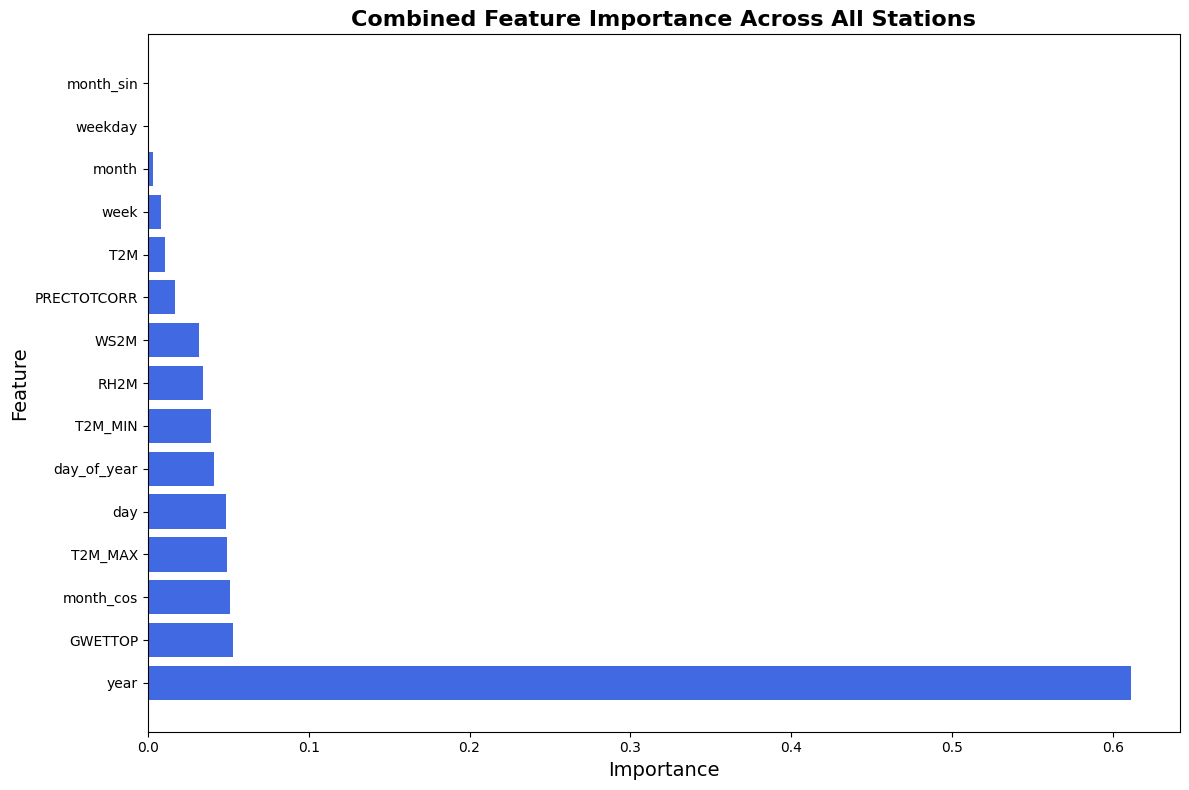

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9524
Training Gradient Boosting model...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Gradient Boosting Accuracy: 0.9683
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 1.0000
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9841
Plotting combined feature importance for all stations...


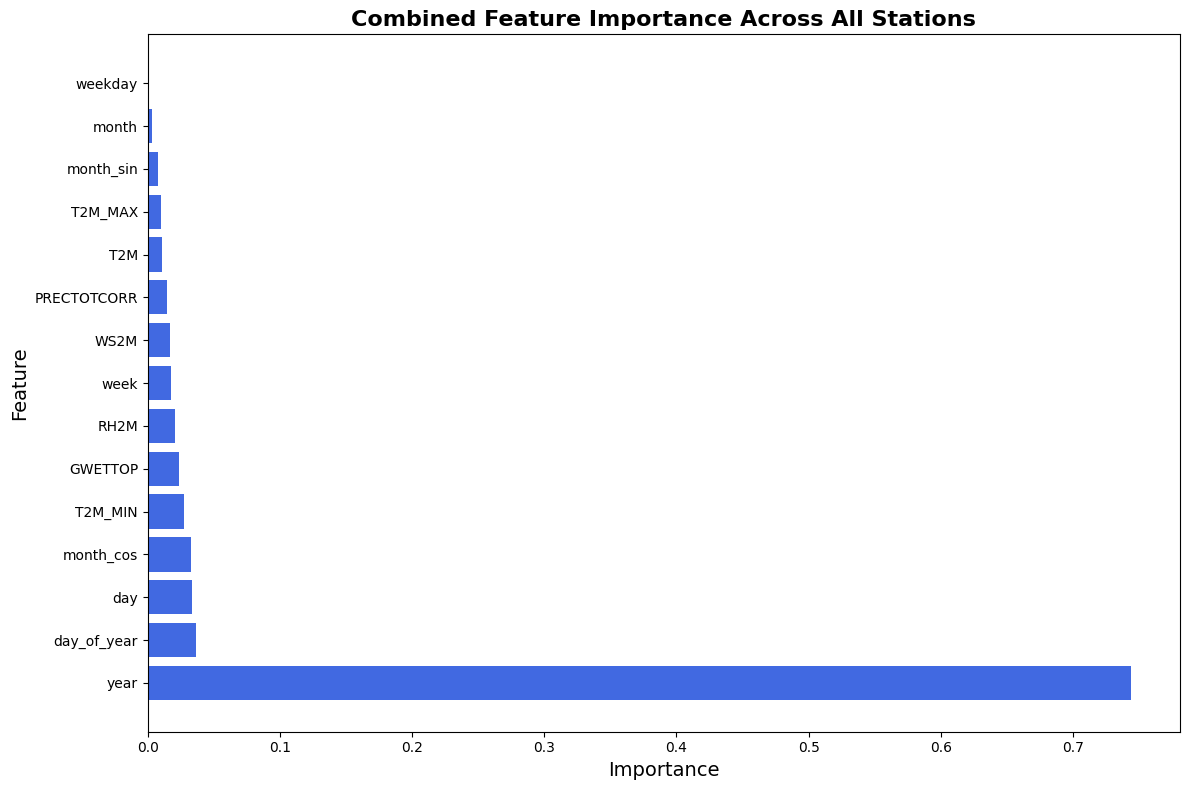

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9206
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9048
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9365
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9841
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


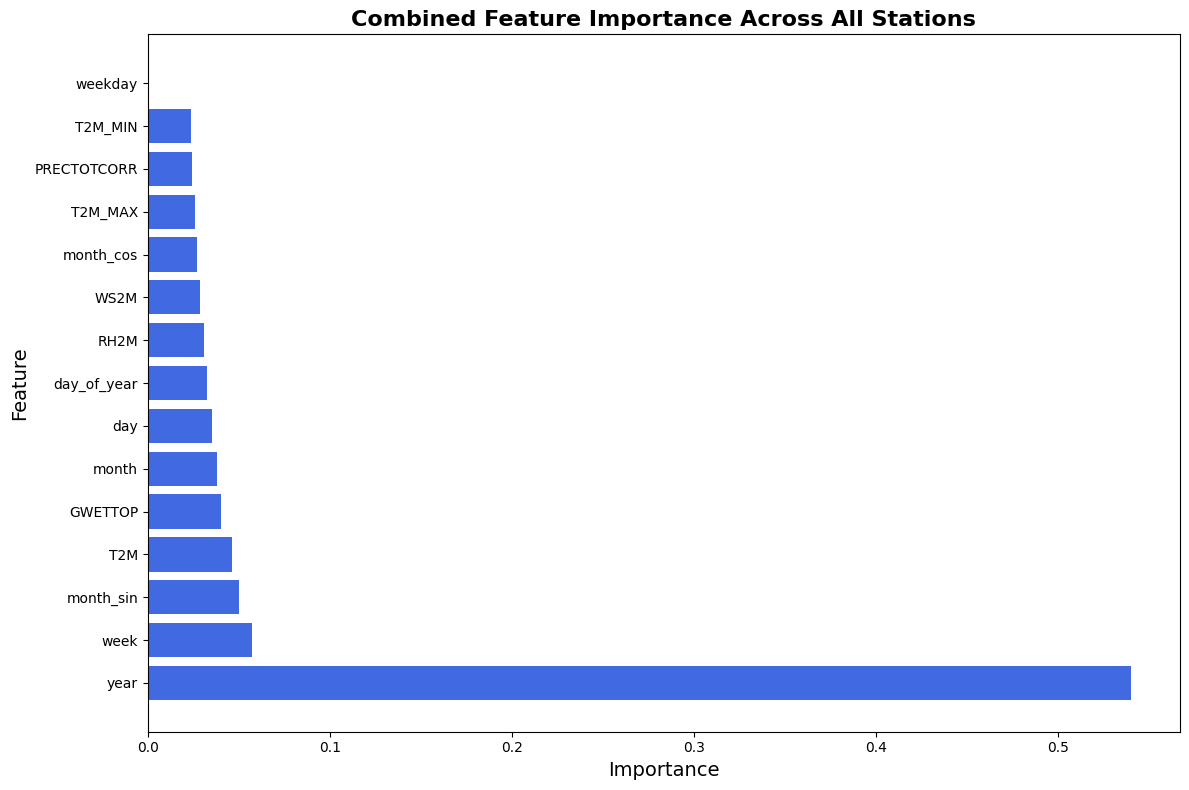

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9365
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9683
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9365
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9683
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


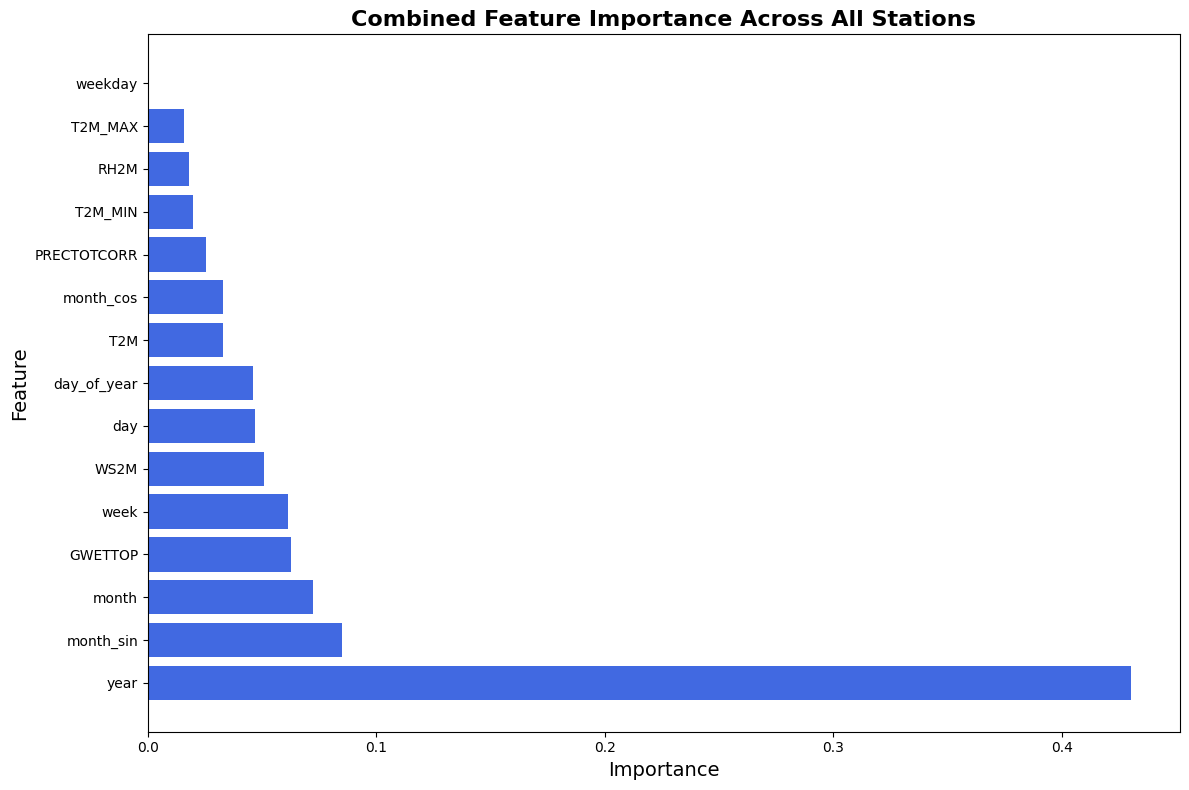

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.8730
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.8571
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.8730
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.8571
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


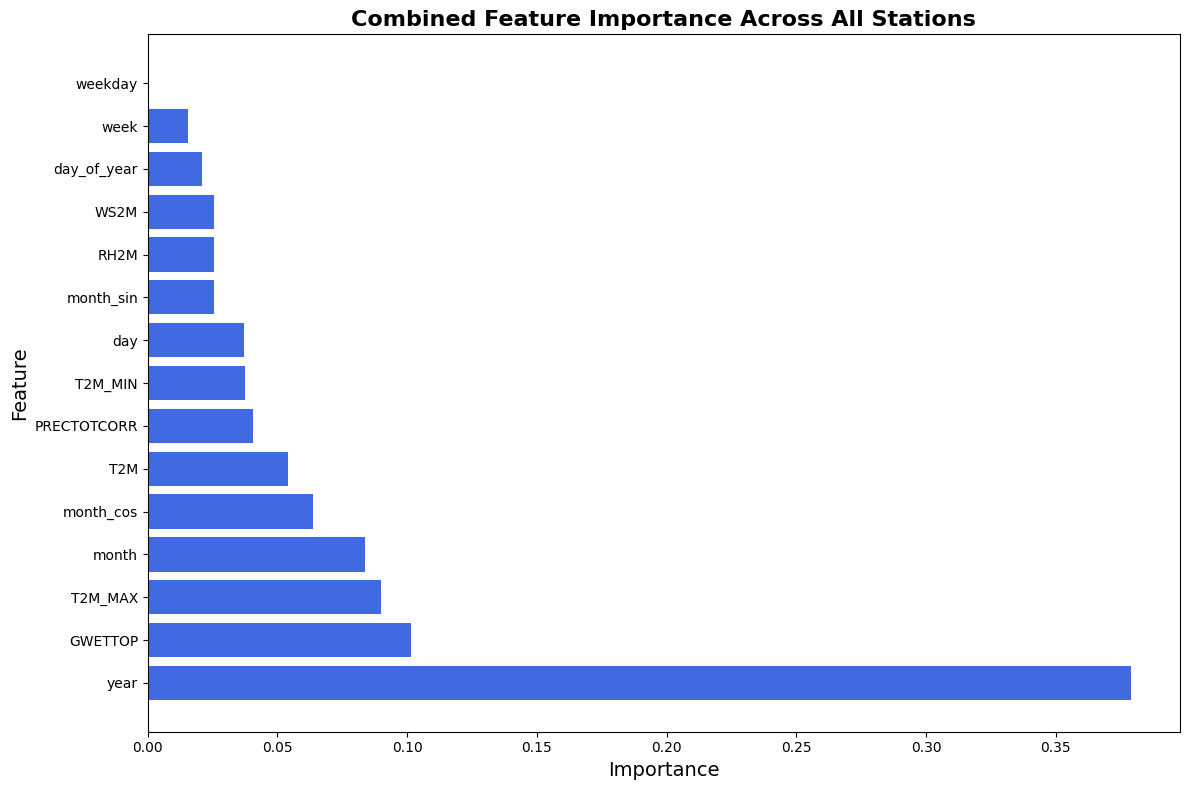

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9524
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9524
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9841
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9841
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


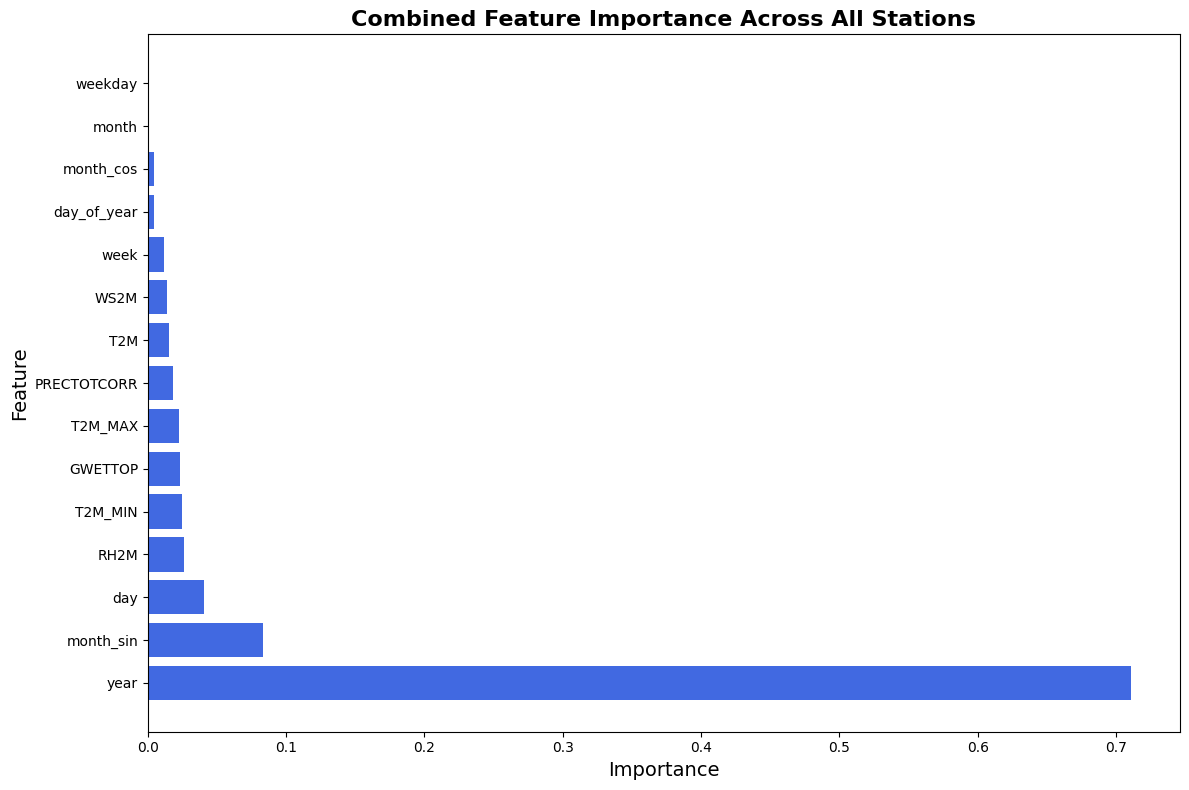

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.8571
Training Gradient Boosting model...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Gradient Boosting Accuracy: 0.8254
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9365
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9683
Plotting combined feature importance for all stations...


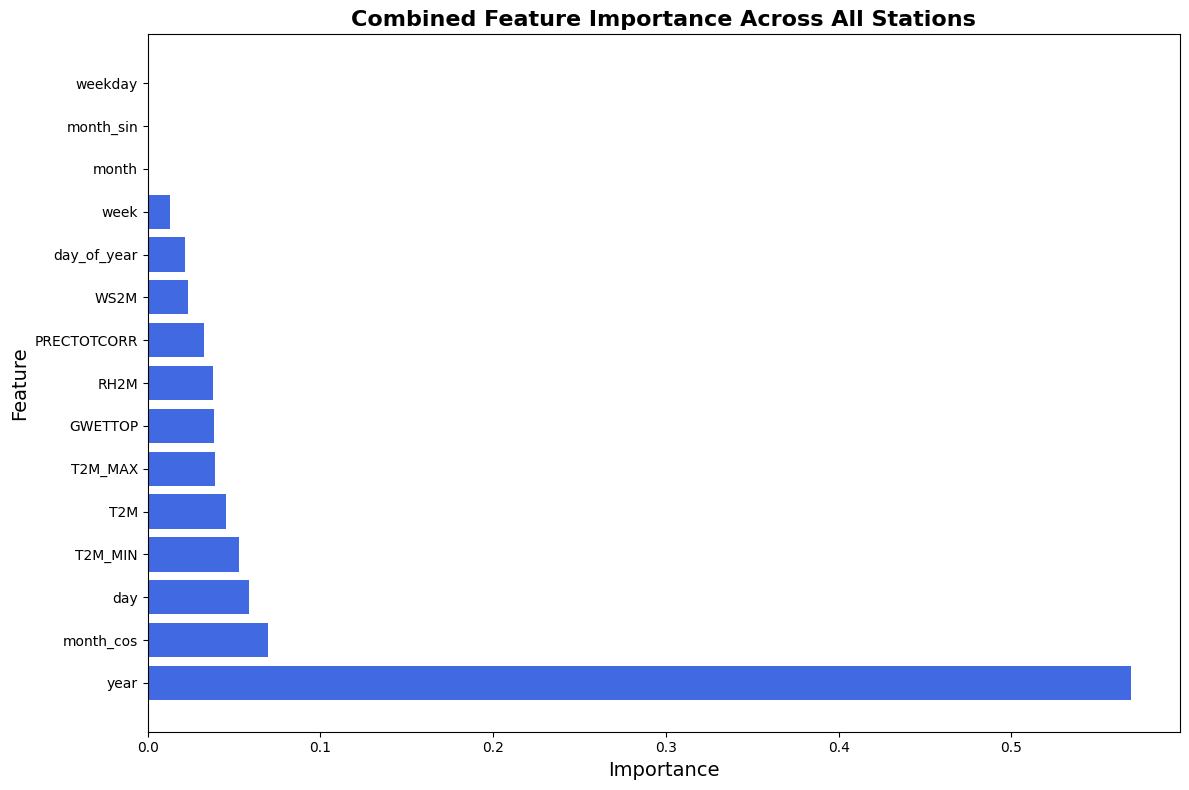

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9524
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9365
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9365
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9524
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


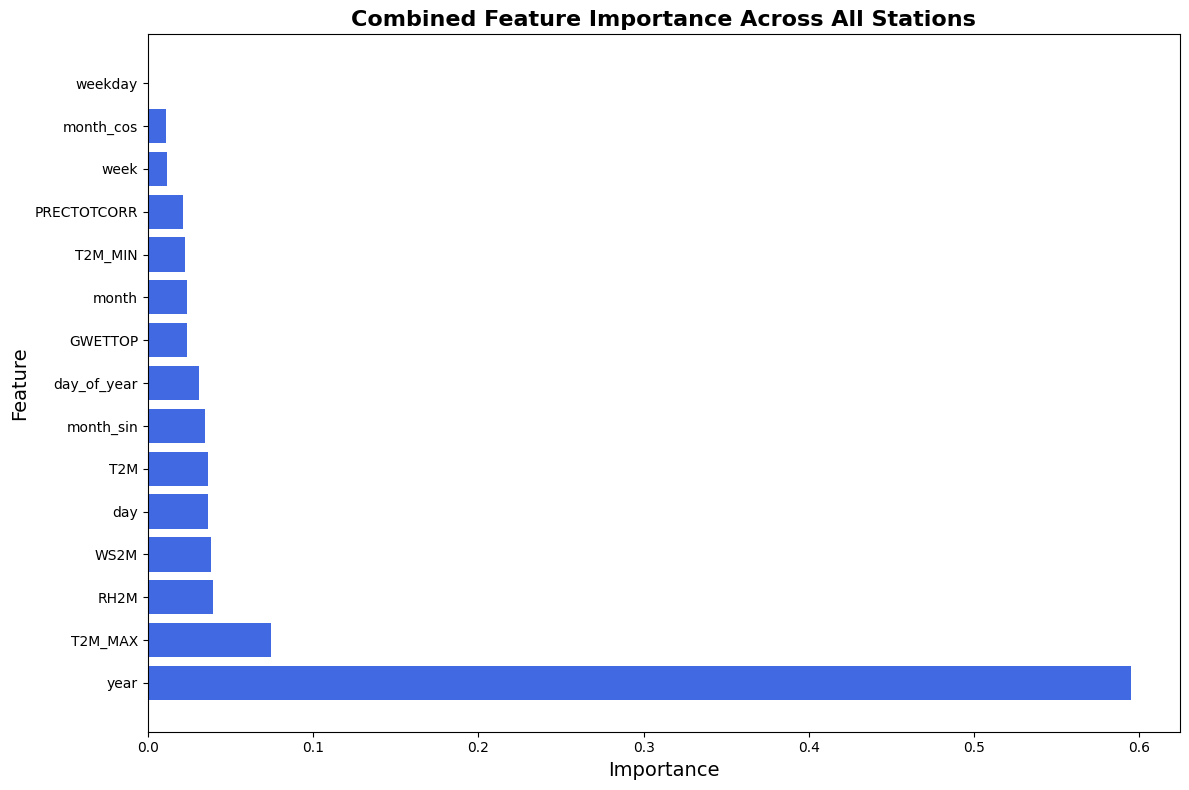

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.8889
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.8889
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9365
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9683
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


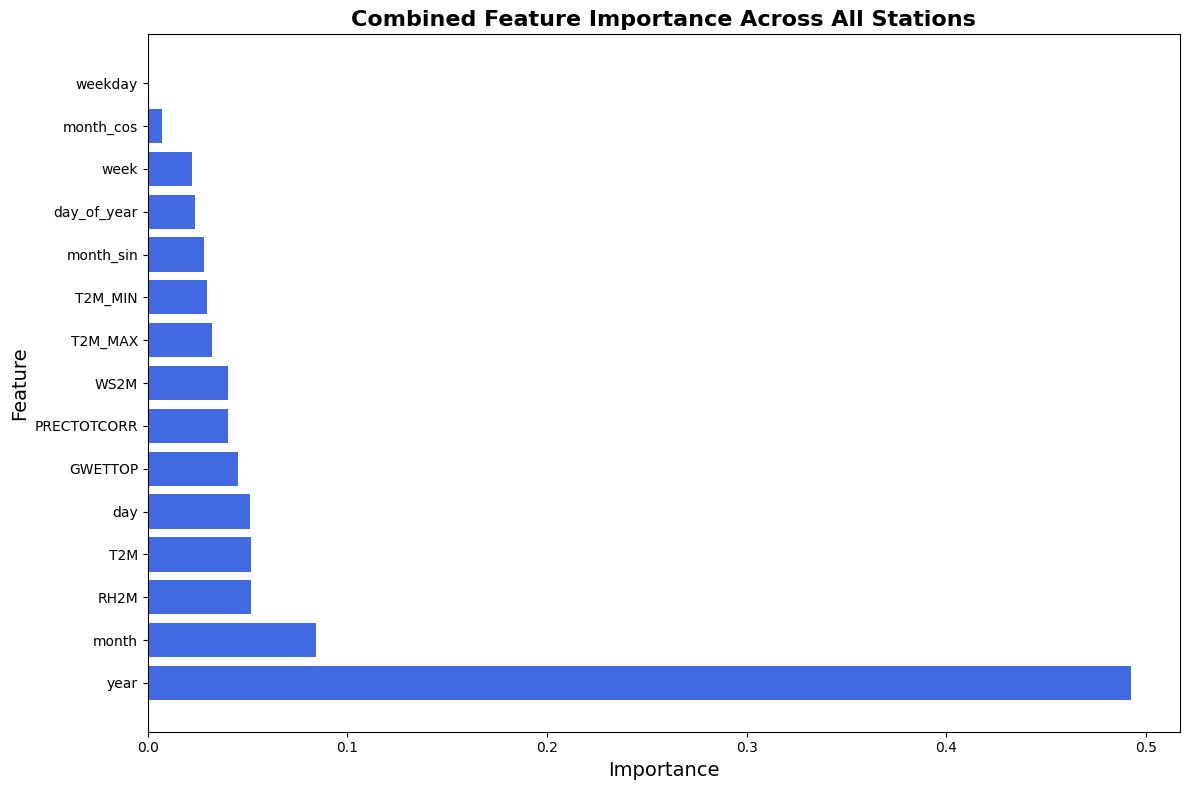

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9048
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.8730
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9206
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9841
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


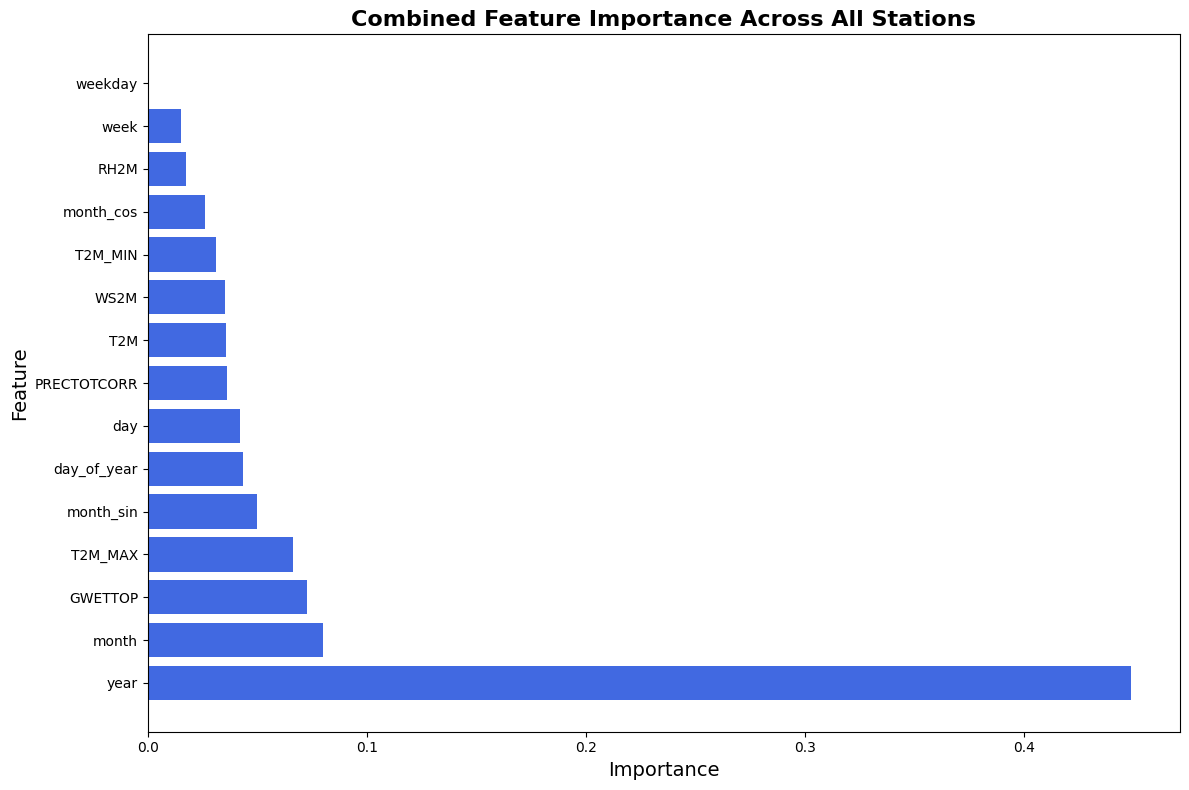

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9206
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9365
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9206
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9365
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


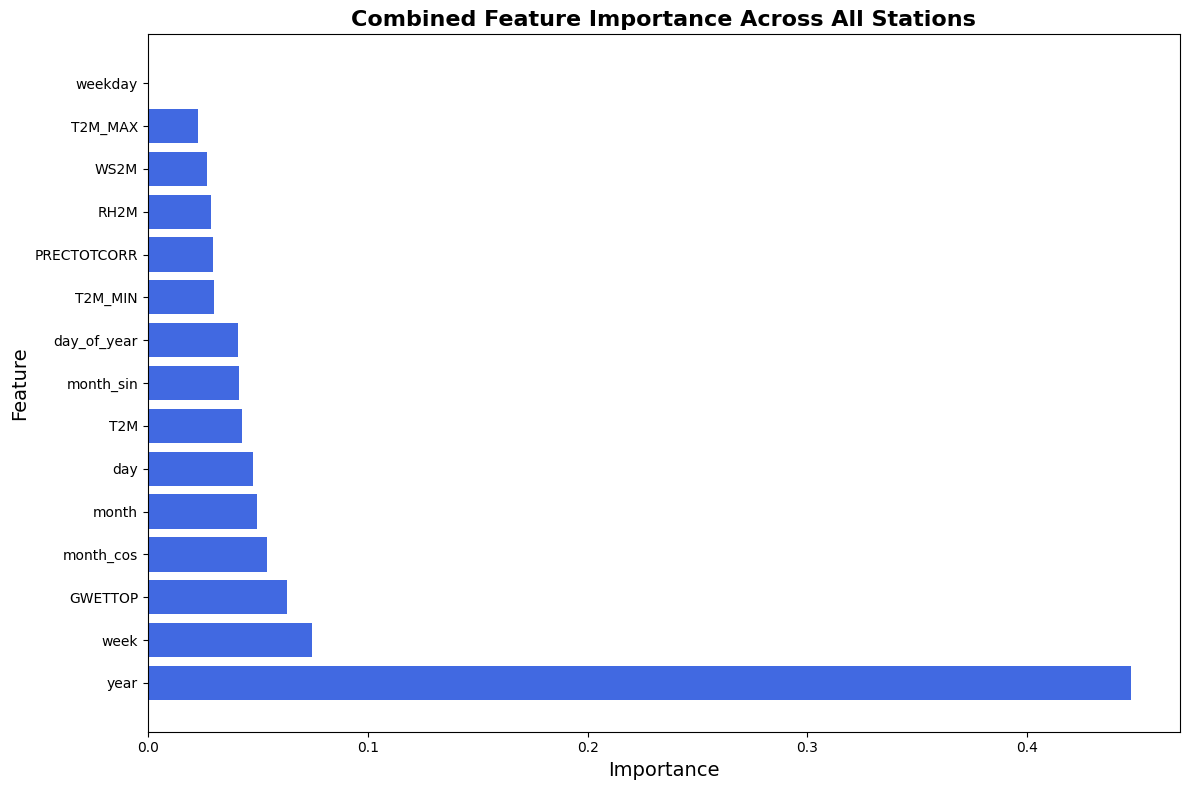

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.7937
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.8095
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9206
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9206
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


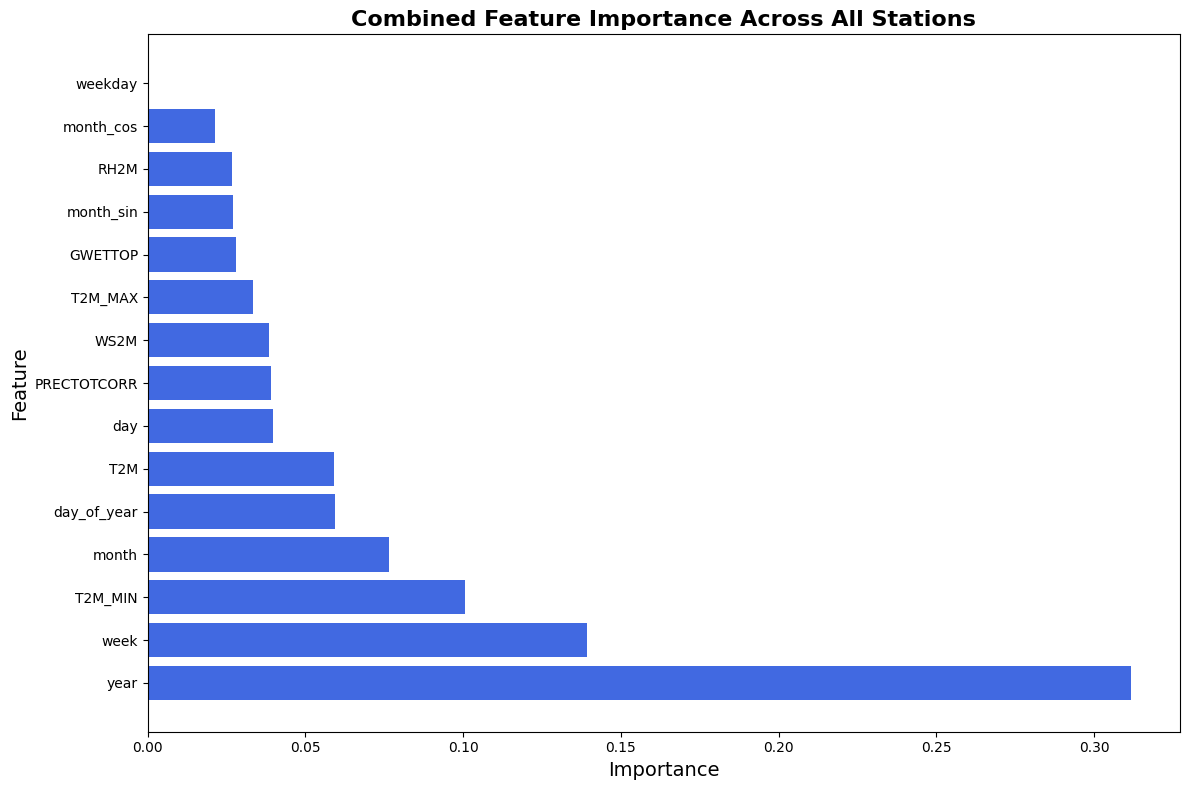

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.8889
Training Gradient Boosting model...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Gradient Boosting Accuracy: 0.8571
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9683
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9365
Plotting combined feature importance for all stations...


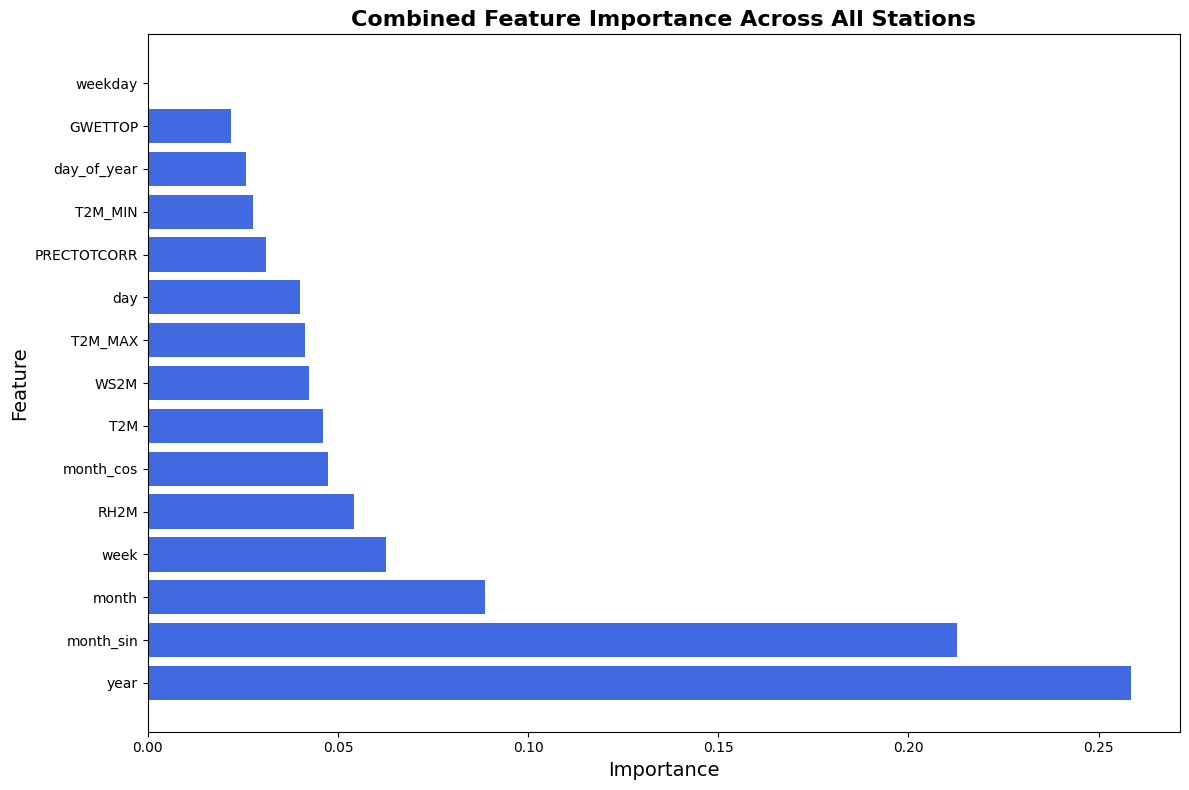

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.8889
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9048
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.8571
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.8889
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


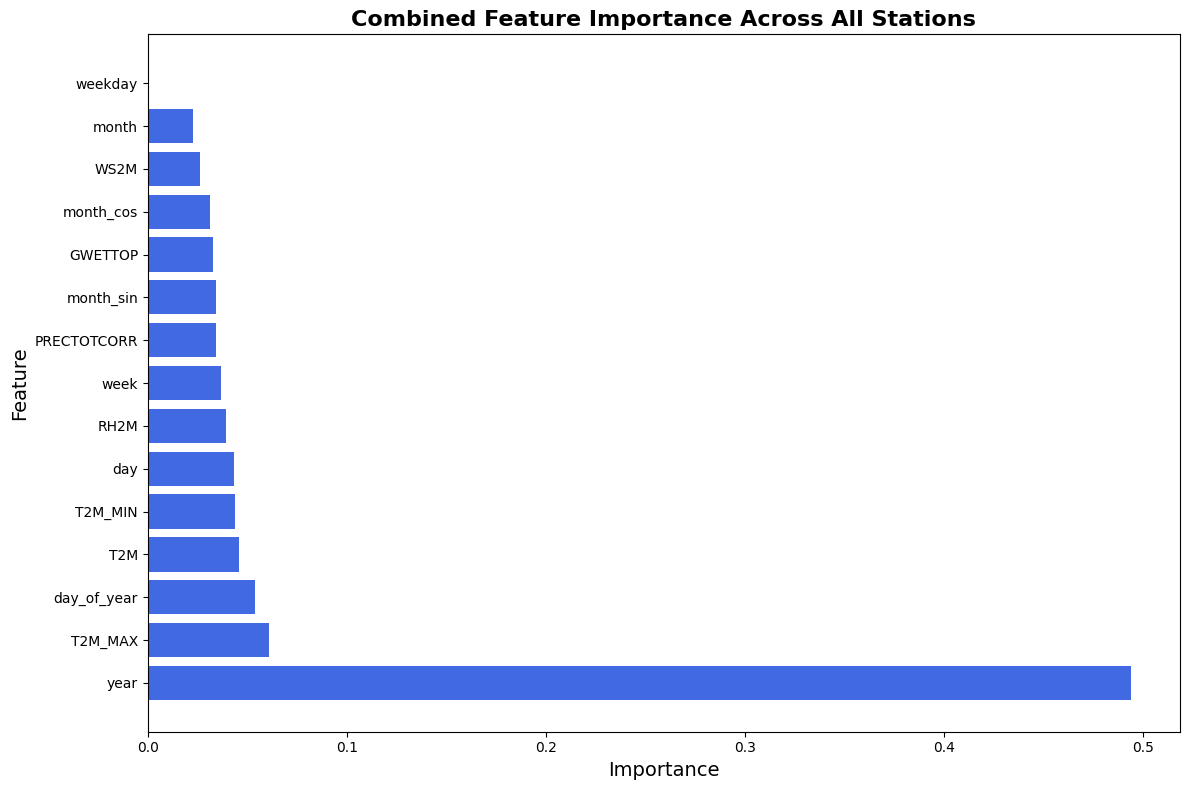

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9206
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9206
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9841
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9841
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


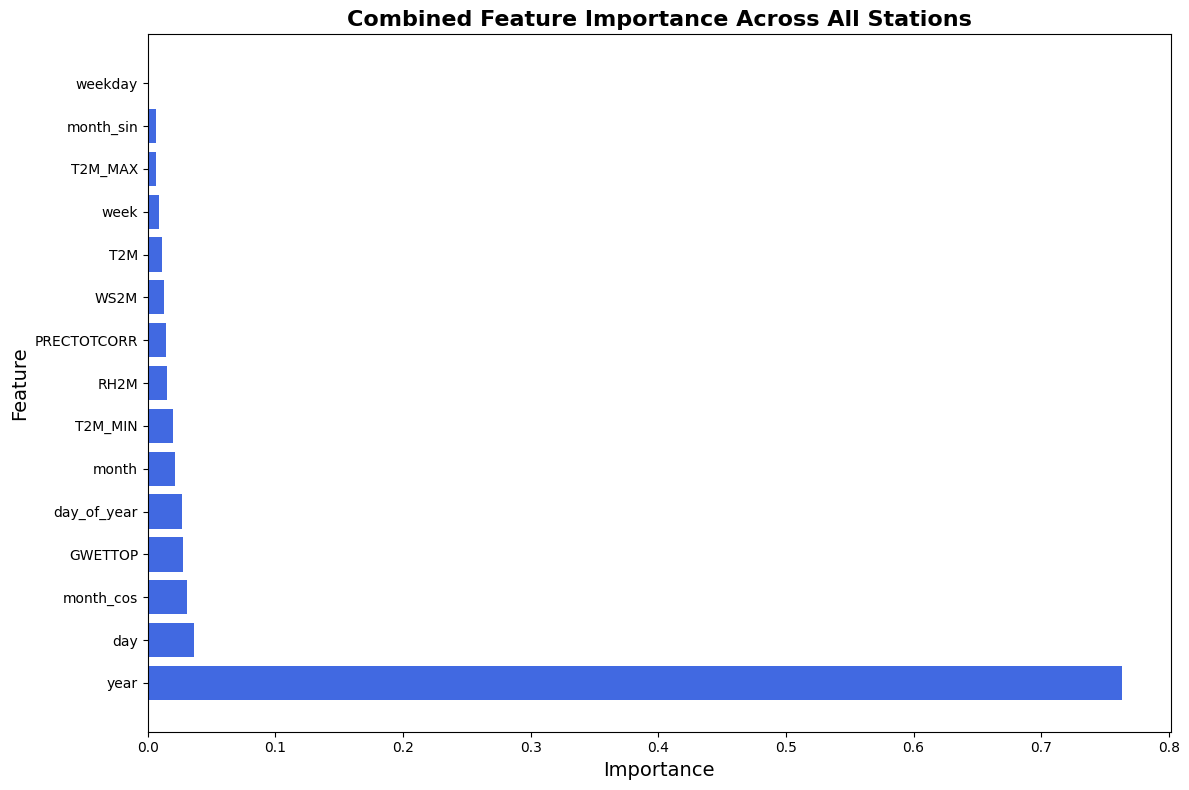

Model xgb saved successfully!
Model gb saved successfully!
Preprocessing data...
Preprocessing completed!
Training XGBoost model...
XGBoost Accuracy: 0.9683
Training Gradient Boosting model...
Gradient Boosting Accuracy: 0.9683
Training surrogate decision tree for xgb...
Surrogate Decision Tree Accuracy (xgb): 0.9841
Training surrogate decision tree for gb...
Surrogate Decision Tree Accuracy (gb): 0.9841
Plotting combined feature importance for all stations...


d:\Malaria data\malaria-outbreak-classifcation_prediction\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


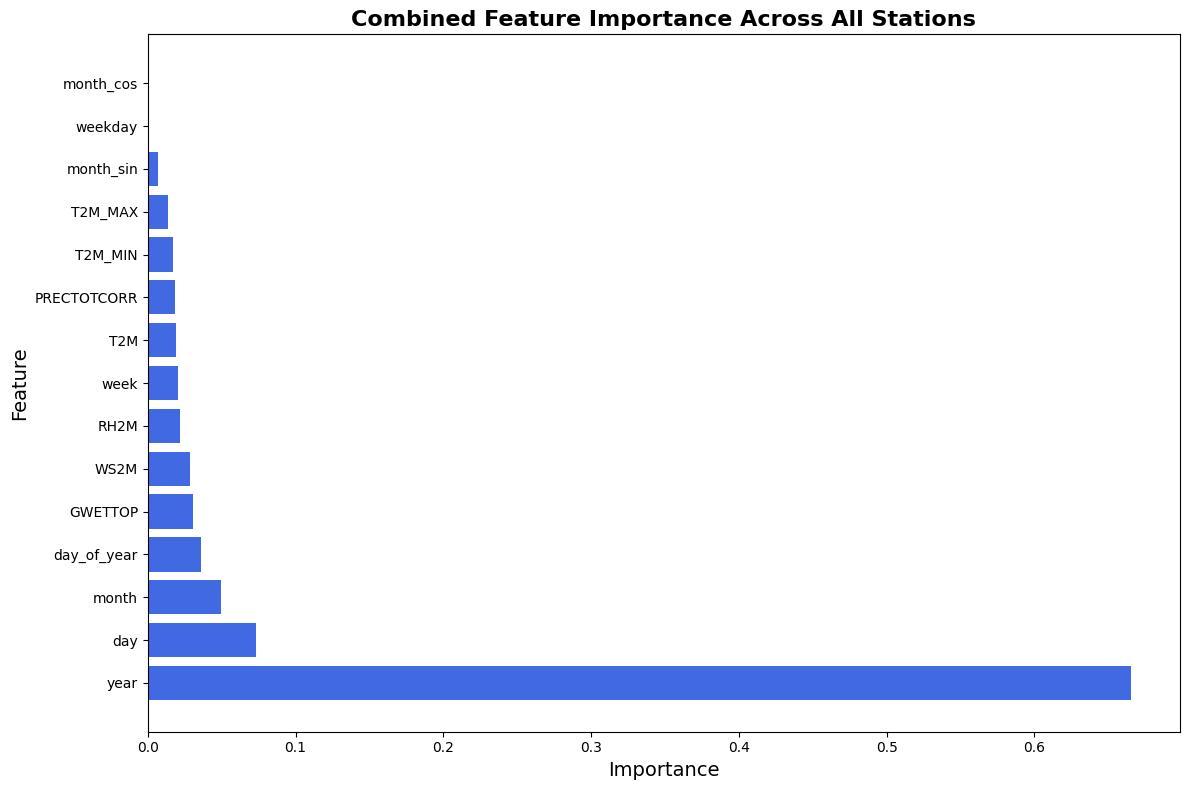

Model xgb saved successfully!
Model gb saved successfully!


In [97]:
import pandas as pd
#from MLAlgorithms import MLAlgorithms  # Ensure the class is imported correctly

# List of dataset files
files = [
    '../Data/merged_weekly_Dambi Dollo Comprehensive  Specialized  Hospital_Q3.csv',
    '../Data/merged_weekly_lalo kile_Q3.csv',
    '../Data/merged_weekly_Dale sadi_Q3.csv',
    '../Data/merged_weekly_Hawa Gelan_Q3.csv',
    '../Data/merged_weekly_Anfilo_Q3.csv',
    '../Data/merged_weekly_Dale Wabera_Q3.csv',
    '../Data/merged_weekly_Dambi Dollo_Q3.csv',
    '../Data/merged_weekly_gawo kebe_Q3.csv',
    '../Data/merged_weekly_Gidami Primery Hospital_Q3.csv',
    '../Data/merged_weekly_Gidami_Q3.csv',
    '../Data/merged_weekly_Hawa Galan Primery Hospital_Q3.csv',
    '../Data/merged_weekly_jima horo_Q3.csv',
    '../Data/merged_weekly_kake primary hospital_Q3.csv',
    '../Data/merged_weekly_sadi chanka_Q3.csv',
    '../Data/merged_weekly_sayo_Q3.csv',
    '../Data/merged_weekly_Yemalogi Walal_Q3.csv'
]

# Iterate through the files, load data, and use the MLAlgorithms class
for file in files:
    # Load the dataset
    data = pd.read_csv(file)
    
    # Initialize the MLAlgorithms class with the dataset
    model = MLAlgorithms(data)
    
    # Run the full pipeline: preprocessing, training, and evaluation
    model.run()

    # Optionally, you can save the trained models after processing
    model.save_model(model_name='xgb')  # Save XGBoost model
    model.save_model(model_name='gb')   # Save Gradient Boosting model



